In [55]:
import json

with open("../data/mobile_app_logs_2025-06-30.json") as f1, open("../data/internal_plp_logs_2025-06-30.json") as f2:
    mobile_logs = json.load(f1)
    plp_logs = json.load(f2)

logs = mobile_logs + plp_logs

In [56]:
import pandas as pd
from datetime import datetime

df = pd.DataFrame(logs)

df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['endpoint'] = df['endpoint'].fillna('unknown')
df['event'] = df['event'].fillna('UNKNOWN_ACTIVITY')


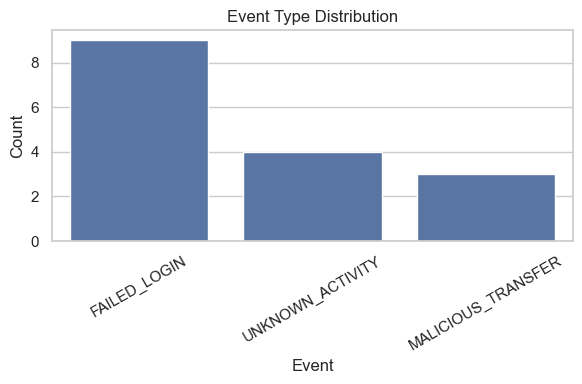

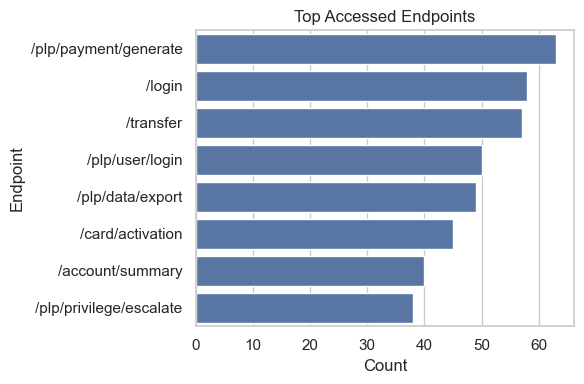

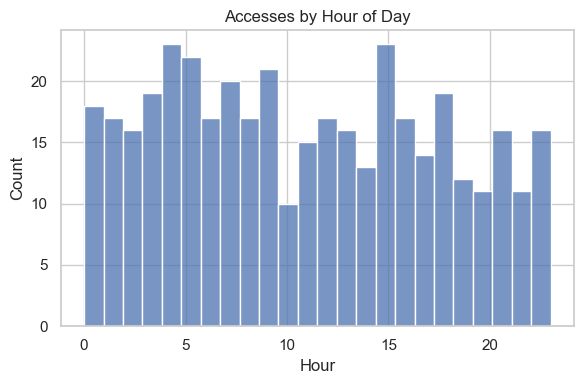

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. Event type distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='event', order=df['event'].value_counts().index[df['event'].value_counts().index != 'NORMAL'])
plt.title("Event Type Distribution")
plt.xlabel("Event")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 2. Endpoint frequency
plt.figure(figsize=(6,4))
sns.countplot(data=df, y='endpoint', order=df['endpoint'].value_counts().index)
plt.title("Top Accessed Endpoints")
plt.xlabel("Count")
plt.ylabel("Endpoint")
plt.tight_layout()
plt.show()

# 3. Access time distribution
plt.figure(figsize=(6,4))
sns.histplot(df['hour'], bins=24, kde=False)
plt.title("Accesses by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [58]:
from sklearn.preprocessing import LabelEncoder
import pickle
import os

event_encoder = LabelEncoder()

df['event_encoded'] = event_encoder.fit_transform(df['event'])

X = df[['hour', 'event_encoded']]

os.makedirs("ml_cache", exist_ok=True)
with open("ml_cache/event_encoder.pkl", "wb") as f:
    pickle.dump(event_encoder, f)


In [59]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer
import numpy as np

# Custom scoring function: Lower false positives + false negatives preferred
def anomaly_score(estimator, X):
    preds = estimator.predict(X)
    # IsolationForest labels: -1 for anomaly, 1 for normal
    # Let's assume label -1 is 1 (anomaly) and 1 is 0 (normal) for scoring simplicity
    return np.mean(preds == -1)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'contamination': [0.05, 0.1, 0.15],
    'max_samples': ['auto', 0.6, 0.8],
    'bootstrap': [False, True]
}

# Grid search setup
grid = GridSearchCV(
    IsolationForest(random_state=42),
    param_grid,
    scoring=make_scorer(anomaly_score),
    cv=3,
    n_jobs=-1
)

# Fit and get best estimator
grid.fit(X)
best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)

# Save best model
with open("ml_cache/iforest_model.pkl", "wb") as f:
    pickle.dump(best_model, f)


c:\Users\USER\Desktop\soc analyst ai agent\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Params: {'bootstrap': False, 'contamination': 0.05, 'max_samples': 'auto', 'n_estimators': 50}


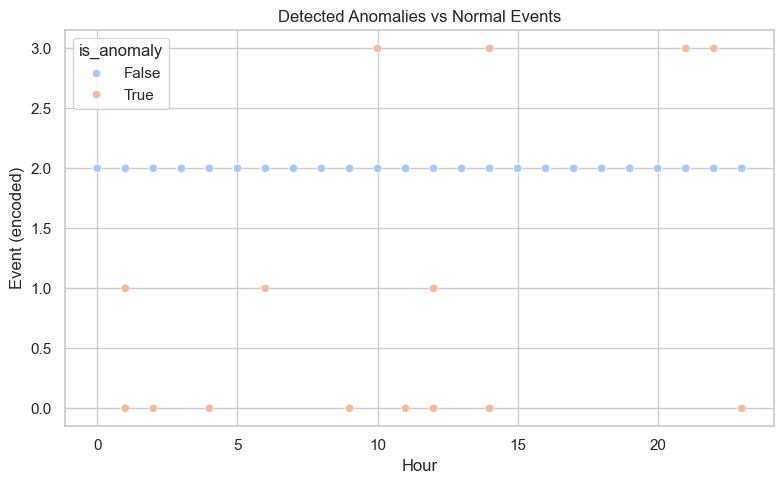

In [60]:
# Add prediction column
df['anomaly_score'] = best_model.decision_function(X)
df['is_anomaly'] = best_model.predict(X) == -1

# 4. Scatter plot of anomalies
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='hour', y='event_encoded', hue='is_anomaly', palette='coolwarm')
plt.title("Detected Anomalies vs Normal Events")
plt.xlabel("Hour")
plt.ylabel("Event (encoded)")
plt.tight_layout()
plt.show()
